# Setup

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import(
    Sequential,
    layers,
    regularizers,
    activations,
    losses,
    optimizers
)
import tensorflow_hub as hub

In [2]:
print(tf.version.VERSION)
device_name = tf.config.list_physical_devices()
device_name

2.8.0


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(5 * len(metrics), 5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric], ls='dashed')
        ax[idx].set_xlabel('Epochs')
        ax[idx].set_ylabel(metric)
        ax[idx].plot(history.history['val_' + metric])
        ax[idx].legend([metric, 'val_' + metric])

In [4]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
CLASS_NAMES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
TRAIN_DATA_PATH = 'gs://practical-ml-vision-book/flowers_tfr/train-*'
VALID_DATA_PATH = 'gs://practical-ml-vision-book/flowers_tfr/valid-*'

# Reading TF Records

In [5]:
def parse_tfr(protobuf):
    feature_description = {
        'image': tf.io.VarLenFeature(tf.float32),
        'shape': tf.io.VarLenFeature(tf.int64),
        'label': tf.io.FixedLenFeature([], tf.string, default_value=''),
        'label_int': tf.io.FixedLenFeature([], tf.int64, default_value=0)
    }
    rec = tf.io.parse_single_example(
        protobuf, feature_description
    )
    shape = tf.sparse.to_dense(rec['shape'])
    img = tf.reshape(tf.sparse.to_dense(rec['image']), shape)
    label_int = rec['label_int']
    return img, label_int

## Display some examples

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

The size of the image is (240, 320, 3)
The mean of the image is 0.35263803601264954
The label of the image is 4
The size of the image is (213, 320, 3)
The mean of the image is 0.698478639125824
The label of the image is 4
The size of the image is (240, 320, 3)
The mean of the image is 0.22729656100273132
The label of the image is 4
The size of the image is (333, 500, 3)
The mean of the image is 0.276783287525177
The label of the image is 4
The size of the image is (240, 320, 3)
The mean of the image is 0.3930550813674927
The label of the image is 1


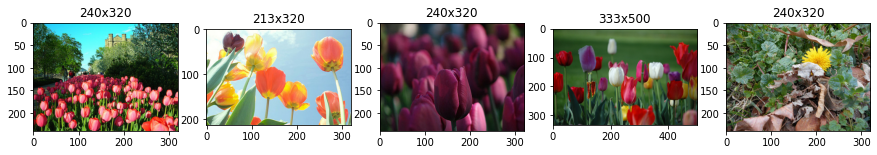

In [6]:
train_dataset = tf.data.TFRecordDataset(
    [filename for filename in tf.io.gfile.glob(TRAIN_DATA_PATH)],
    compression_type='GZIP'
).map(parse_tfr)

f, ax = plt.subplots(1, 5, figsize=(15, 15))
for idx, (img, label_int) in enumerate(train_dataset.take(5)):
    print(f'The size of the image is {img.shape}')
    mean_of_image = tf.reduce_mean(img)
    print(f'The mean of the image is {mean_of_image}')
    print(f'The label of the image is {label_int}')
    ax[idx].imshow(img.numpy())
    ax[idx].set_title(f'{img.shape[0]}x{img.shape[1]}')
    

### Apply the resizing with Keras layers

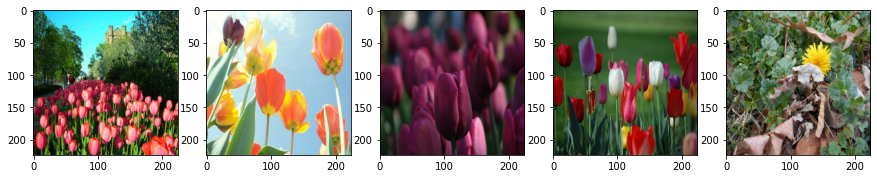

In [7]:
preproc_layers = Sequential(
    [layers.Resizing(height=IMG_HEIGHT, width=IMG_WIDTH, input_shape=(None, None, 3))]
)

def apply_preproc(img, label):
    x = tf.expand_dims(img, 0)
    x = preproc_layers(x)
    x = tf.squeeze(x, 0)
    return x, label

f, ax = plt.subplots(1, 5, figsize=(15, 15))
for idx, (img, label) in enumerate(train_dataset.map(apply_preproc).take(5)):
    ax[idx].imshow(img.numpy())

## Apply zero-padding with Tensorflow

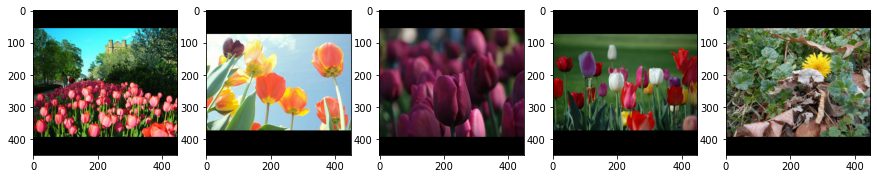

In [8]:
def apply_preproc(img, label):
    return tf.image.resize_with_pad(img, 2*IMG_HEIGHT, 2*IMG_WIDTH), label

f, ax = plt.subplots(1, 5, figsize=(15, 15))
for idx, (img, label) in enumerate(train_dataset.map(apply_preproc).take(5)):
    ax[idx].imshow(img.numpy())

### Combining Keras and Tensorflow

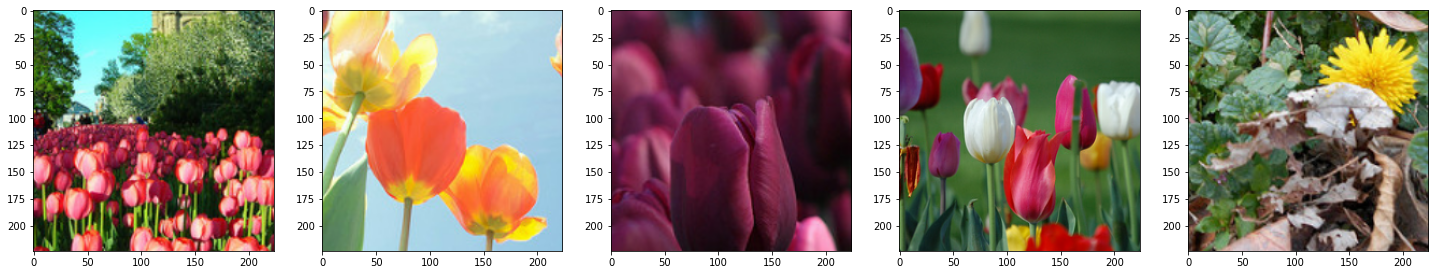

In [9]:
preproc_layers = Sequential(
    [
        layers.Lambda(
            lambda img: tf.image.resize_with_pad(img, 2 * IMG_HEIGHT, 2 * IMG_WIDTH),
            input_shape=(None, None, 3),
        ),
        layers.CenterCrop(height=IMG_HEIGHT, width=IMG_WIDTH),
    ]
)

def apply_preproc(img, label):
    x = tf.expand_dims(img, 0)
    x = preproc_layers(x)
    x = tf.squeeze(x, 0)
    return x, label

f, ax = plt.subplots(1, 5, figsize=(25, 25))
for idx, (img, label) in enumerate(train_dataset.map(apply_preproc).take(5)):
    ax[idx].imshow(img.numpy())

# Transfer Learning with MobileNet

In [10]:
os.environ["THUB_MODEL_LOAD_FORMAT"] = "COMPRESSED"

preproc_layers = Sequential(
    [
        layers.Lambda(
            lambda img: tf.image.resize_with_pad(img, 2 * IMG_HEIGHT, 2 * IMG_WIDTH),
            input_shape=(None, None, 3),
        ),
        layers.CenterCrop(height=IMG_HEIGHT, width=IMG_WIDTH),
    ]
)


def apply_preproc(img, label):
    x = tf.expand_dims(img, 0)
    x = preproc_layers(x)
    x = tf.squeeze(x, 0)
    return x, label


def train_and_evaluate(batch_size=32, lrate=1e-3, l1=0, l2=0, num_hidden=16):
    regularizer = regularizers.l1_l2(l1, l2)

    train_dataset = (
        tf.data.TFRecordDataset(
            [
                filename
                for filename in tf.io.gfile.glob(
                    "gs://practical-ml-vision-book/flowers_tfr/train-*"
                )
            ],
            compression_type="GZIP",
        )
        .map(parse_tfr)
        .map(apply_preproc)
        .batch(batch_size=batch_size)
    )

    eval_dataset = (
        tf.data.TFRecordDataset(
            [
                filename
                for filename in tf.io.gfile.glob(
                    "gs://practical-ml-vision-book/flowers_tfr/valid-*"
                )
            ],
            compression_type="GZIP",
        )
        .map(parse_tfr)
        .map(apply_preproc)
        .batch(batch_size=batch_size)
    )

    list_layers = [
        hub.KerasLayer(
            "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
            input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
            trainable=False,
            name="mobilenet_embedding",
        ),
        layers.Dense(
            num_hidden,
            kernel_regularizer=regularizer,
            activation=activations.relu,
            name="dense_hidden",
        ),
        layers.Dense(
            len(CLASS_NAMES),
            kernel_regularizer=regularizer,
            activation="softmax",
            name="flower_prob",
        ),
    ]

    model = Sequential(list_layers, name="flower_classification")

    model.compile(
        optimizer=optimizers.Adam(learning_rate=lrate),
        loss=losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    
    print(model.summary())
    history = model.fit(train_dataset, validation_data = eval_dataset, epochs = 10)
    training_plot(['loss', 'accuracy'], history)
    return model


In [11]:
model = train_and_evaluate()

Model: "flower_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_embedding (KerasL  (None, 1280)             2257984   
 ayer)                                                           
                                                                 
 dense_hidden (Dense)        (None, 16)                20496     
                                                                 
 flower_prob (Dense)         (None, 5)                 85        
                                                                 
Total params: 2,278,565
Trainable params: 20,581
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/10
     92/Unknown - 593s 6s/step - loss: 0.7586 - accuracy: 0.7307

2022-04-08 02:03:19.872888: E tensorflow/core/platform/cloud/curl_http_request.cc:614] The transmission  of request 0x2f06f9f50 (URI: https://storage.googleapis.com/practical-ml-vision-book/flowers_tfr%2Fvalid-00001-of-00002.gz) has been stuck at 59210545 of 67108864 bytes for 934 seconds and will be aborted. CURL timing information: lookup time: 0.001535 (No error), connect time: 0.108549 (No error), pre-transfer time: 0.209947 (No error), start-transfer time: 0.452886 (No error)


FailedPreconditionError: Graph execution error:

Detected at node 'IteratorGetNext' defined at (most recent call last):
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/mmenendezg/Developer/Books/.venv/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/mmenendezg/Developer/Books/.venv/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/Users/mmenendezg/Developer/Books/.venv/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 707, in start
      self.io_loop.start()
    File "/Users/mmenendezg/Developer/Books/.venv/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
      self._run_once()
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
      handle._run()
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/mmenendezg/Developer/Books/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 502, in dispatch_queue
      await self.process_one()
    File "/Users/mmenendezg/Developer/Books/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 491, in process_one
      await dispatch(*args)
    File "/Users/mmenendezg/Developer/Books/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 398, in dispatch_shell
      await result
    File "/Users/mmenendezg/Developer/Books/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 722, in execute_request
      reply_content = await reply_content
    File "/Users/mmenendezg/Developer/Books/.venv/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 389, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/Users/mmenendezg/Developer/Books/.venv/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/mmenendezg/Developer/Books/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "/Users/mmenendezg/Developer/Books/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "/Users/mmenendezg/Developer/Books/.venv/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/mmenendezg/Developer/Books/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/mmenendezg/Developer/Books/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/mmenendezg/Developer/Books/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/w1/7wtz55rs63b9743vzqfb8p880000gp/T/ipykernel_23861/1535351443.py", line 1, in <cell line: 1>
      model = train_and_evaluate()
    File "/var/folders/w1/7wtz55rs63b9743vzqfb8p880000gp/T/ipykernel_23861/789501928.py", line 84, in train_and_evaluate
      history = model.fit(train_dataset, validation_data = eval_dataset, epochs = 10)
    File "/Users/mmenendezg/Developer/Books/.venv/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/mmenendezg/Developer/Books/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1420, in fit
      val_logs = self.evaluate(
    File "/Users/mmenendezg/Developer/Books/.venv/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/mmenendezg/Developer/Books/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1716, in evaluate
      tmp_logs = self.test_function(iterator)
    File "/Users/mmenendezg/Developer/Books/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1525, in test_function
      return step_function(self, iterator)
    File "/Users/mmenendezg/Developer/Books/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1513, in step_function
      data = next(iterator)
Node: 'IteratorGetNext'
Detected at node 'IteratorGetNext' defined at (most recent call last):
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/mmenendezg/Developer/Books/.venv/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/mmenendezg/Developer/Books/.venv/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/Users/mmenendezg/Developer/Books/.venv/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 707, in start
      self.io_loop.start()
    File "/Users/mmenendezg/Developer/Books/.venv/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
      self._run_once()
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
      handle._run()
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/mmenendezg/Developer/Books/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 502, in dispatch_queue
      await self.process_one()
    File "/Users/mmenendezg/Developer/Books/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 491, in process_one
      await dispatch(*args)
    File "/Users/mmenendezg/Developer/Books/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 398, in dispatch_shell
      await result
    File "/Users/mmenendezg/Developer/Books/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 722, in execute_request
      reply_content = await reply_content
    File "/Users/mmenendezg/Developer/Books/.venv/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 389, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/Users/mmenendezg/Developer/Books/.venv/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/mmenendezg/Developer/Books/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "/Users/mmenendezg/Developer/Books/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "/Users/mmenendezg/Developer/Books/.venv/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/mmenendezg/Developer/Books/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/mmenendezg/Developer/Books/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/mmenendezg/Developer/Books/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/w1/7wtz55rs63b9743vzqfb8p880000gp/T/ipykernel_23861/1535351443.py", line 1, in <cell line: 1>
      model = train_and_evaluate()
    File "/var/folders/w1/7wtz55rs63b9743vzqfb8p880000gp/T/ipykernel_23861/789501928.py", line 84, in train_and_evaluate
      history = model.fit(train_dataset, validation_data = eval_dataset, epochs = 10)
    File "/Users/mmenendezg/Developer/Books/.venv/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/mmenendezg/Developer/Books/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1420, in fit
      val_logs = self.evaluate(
    File "/Users/mmenendezg/Developer/Books/.venv/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/mmenendezg/Developer/Books/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1716, in evaluate
      tmp_logs = self.test_function(iterator)
    File "/Users/mmenendezg/Developer/Books/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1525, in test_function
      return step_function(self, iterator)
    File "/Users/mmenendezg/Developer/Books/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1513, in step_function
      data = next(iterator)
Node: 'IteratorGetNext'
2 root error(s) found.
  (0) FAILED_PRECONDITION:  Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: storage.googleapis.com
	 when reading gs://practical-ml-vision-book/flowers_tfr/valid-00001-of-00002.gz
	 [[{{node IteratorGetNext}}]]
	 [[flower_classification/mobilenet_embedding/StatefulPartitionedCall/StatefulPartitionedCall/StatefulPartitionedCall/predict/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/FusedBatchNorm/_354]]
  (1) FAILED_PRECONDITION:  Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: storage.googleapis.com
	 when reading gs://practical-ml-vision-book/flowers_tfr/valid-00001-of-00002.gz
	 [[{{node IteratorGetNext}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_test_function_19756]